In [11]:
import numpy as np
import pandas as pd
from PIL import Image
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from deeplab import Deeplabv3
import cv2
import imutils
import math

In [2]:
collar_model = Deeplabv3(input_shape=(256, 256, 3), classes=1)
collar_model.load_weights('./pretrained_weights/deeplab_collar_lite.hdf5')
arm_model = Deeplabv3(input_shape = (256,256,3), classes = 6)
arm_model.load_weights('./pretrained_weights/deeplab_arm_lite.hdf5')


In [3]:
all_images = glob.glob('./testset/*.jpg')

In [4]:
def preprocess_collar(img, alpha):
    alpha = 1 - (alpha==0)
    cropped_img_1 = cropping(img, alpha, delta = 10)
    cropped_img_2, img_1 = resize_special(cropped_img_1, 5.5)
    new_img = np.expand_dims(cropped_img_2, axis = 0)
    new_img = new_img / 255.0
    return new_img, cropped_img_1, img_1

In [5]:
def get_extreme_points(image):
    cnts = cv2.findContours(image.astype(np.uint8).copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    ext_left = tuple(c[c[:, :, 0].argmin()][0])
    ext_right = tuple(c[c[:, :, 0].argmax()][0])
    ext_top = tuple(c[c[:, :, 1].argmin()][0])
    ext_bottom = tuple(c[c[:, :, 1].argmax()][0])
    xmin = ext_left[0]; ymin = ext_top[1]; xmax = ext_right[0]; ymax = ext_bottom[1]
    return xmin, ymin, xmax, ymax

In [6]:
def resize(image, shape, string):
    image = Image.fromarray(image)
    if string == 'mask':
        image.thumbnail((shape,shape), resample=Image.LANCZOS)
        image = np.array(image)
        image[image > 0.5] = 1
        image[image < 0.5] =0
    else:
        image.thumbnail((shape,shape), resample=Image.LANCZOS)
        image = np.array(image)
    delh = (shape-image.shape[0])/2. 
    delw = (shape-image.shape[1])/2. 
    new_img = cv2.copyMakeBorder(image, math.floor(delh) + math.ceil(delh), 0, math.floor(delw), math.ceil(delw), cv2.BORDER_CONSTANT, value=image[0,0].tolist())
    return new_img, image

def resize_special(img, hyp = 5.5):
    delw = np.int(img.shape[1]/hyp)
    delta = img.shape[1] - delw
    delh = np.abs(delw-delta)
    img_1 = img[:delh, delw:delta]
    img = cv2.resize(img_1.astype(np.uint8), (256,256))
    return img, img_1

def cropping(img, alpha, delta = 10):
    img = np.array(img); alpha = np.array(alpha)
    xmin,ymin, xmax, ymax = get_extreme_points(alpha)
    height, width, _ = img.shape
    img = img[max((ymin-delta), 0):min((ymax + delta), height),max((xmin-delta), 0):min((xmax + delta), width)]
    return img

In [7]:
def decode_collar_output(mask, crp_1 ,crp_2, img, alpha, hyp = 5.5, delta = 10):
    #1st phase of decoding
#     alpha = np.argmax(alpha, axis = -1)
    delw = np.int(crp_1.shape[1]/hyp)
    delta = crp_1.shape[1] - delw
    delh = np.abs(delw-delta)
    new_mask = cv2.resize(mask.astype(np.uint8), (crp_2.shape[1], crp_2.shape[0]))
    new_mask = cv2.copyMakeBorder(new_mask, 0, crp_1.shape[0]-delh, delw, delw, 0)
    #2nd phase of decoding
    h = img.shape[0]
    w = img.shape[1]
    xmin, ymin, xmax, ymax = get_extreme_points(1-(alpha==0))
    xmin = max(xmin - 10, 0); xmax = min(xmax + 10, alpha.shape[1])
    ymin = max(ymin - 10, 0); ymax = min(ymax + 10, alpha.shape[0])
    y0 = ymin
    y1 = img.shape[0]- ymax
    x0 = xmin
    x1 = img.shape[1]- xmax
    new_mask = cv2.copyMakeBorder(new_mask, y0, y1, x0, x1, 0)
    new_mask = new_mask * (alpha==5)
    return new_mask

In [8]:
def preprocess_arm(img):
    shape = (img.size[0], img.size[1])
    img, img_1 = resize(np.array(img), 256, None)
    img = np.expand_dims(img, axis = 0)
    img = img / 255.0
    return img,img_1
    
import math

In [16]:
def RetColor(im):
    color = np.asarray([[0,0,0],[1,1,1],[0,1,0],[0,0,1],[1,0,0],[1,1,0], [1,0,1]])*255
    ret_im = np.zeros((im.shape[0],im.shape[1],3))
    ret_im = color[im]
    return ret_im

In [108]:
for path in all_images:
    ID = path.split('/')[-1].split('.')[0]
    img = Image.open(path).convert('RGB')
    arm_input, img_1 = preprocess_arm(img)
    arm_output =arm_model.predict(arm_input)[0]
    arm_output = decode_arm_output(arm_output, img_1, np.array(img))
    collar_input, crp_1, crp_2 = preprocess_collar(img, arm_output)
    collar_output = collar_model.predict(collar_input)[0]
    collar_output = collar_output > 0.3
    collar_output = decode_collar_output(collar_output, crp_1 , crp_2,  np.array(img), arm_output, hyp = 5.5, delta = 10 )
    indices = np.nonzero(collar_output)
    arm_output[indices] = 6
#     plt.imshow(RetColor(arm_output))
#     plt.imshow(img, alpha = 0.5)
#     plt.show()
    output = Image.fromarray(RetColor(arm_output).astype(np.uint8))
    output.save(f'./output/{ID}.png')


In [106]:
def decode_arm_output(output, img_1, img):
    delh = img_1.shape[0] - output.shape[0]
    delw = np.abs((img_1.shape[1] - output.shape[1])//2)
    output = output[:, delw:output.shape[1]-delw]
    shape = (img.shape[1], img.shape[0])
    output = cv2.resize(output, shape)
    output = np.argmax(output, axis = -1)
    return output

In [94]:
x = decode_arm_output(arm_output, img_1, np.array(img))

TypeError: Invalid shape () for image data

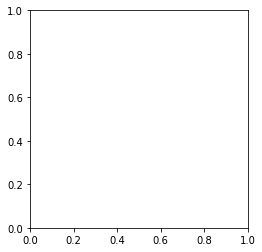

In [105]:
plt.imshow(arm_output)

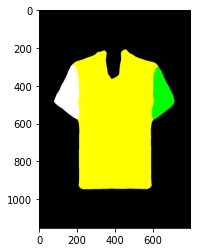

In [101]:
plt.imshow(RetColor(np.argmax(x, axis = -1)))

In [378]:
new_mask.shape

NameError: name 'new_mask' is not defined